In [1]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from statsmodels.formula.api import ols

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency

import datetime
import calendar

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/Fraud_Data.csv")
IP_table = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/IpAddress_to_Country.csv")

In [3]:
dataset["time"] = pd.DataFrame(pd.to_datetime(dataset["purchase_time"]) - pd.to_datetime(dataset["signup_time"])).astype(str)
dataset["time"] = dataset["time"].apply(lambda x : x[-8:])
dataset["time"] = pd.to_datetime(dataset['time'],format= '%H:%M:%S' ).dt.time
dataset["time"]

0         03:51:22
1         04:59:04
2         00:00:01
3         16:41:25
4         11:31:01
            ...   
151107    21:27:13
151108    18:41:10
151109    08:00:16
151110    13:28:39
151111    19:01:33
Name: time, Length: 151112, dtype: object

In [4]:
device_duplicates = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           # hence we need to replace the "device_id" column name
device_duplicates.reset_index(level=0, inplace= True)

In [5]:
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

In [6]:
dataset = dataset.merge(device_duplicates, on= "device_id")

# --- 1 ---
# Categorisation column freq_device
# We see a clear correlation between freq_device and fraudulent activities. We are going to split freq_device in 7 categories
dataset.freq_device = dataset.freq_device.apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# We convert signup_time and purchase_time en datetime

dataset.signup_time = pd.to_datetime(dataset.signup_time, format = '%Y-%m-%d %H:%M:%S')
dataset.purchase_time = pd.to_datetime(dataset.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# We add features 

# --- 2 ---
# Column month
dataset["month_purchase"] = dataset.purchase_time.apply(lambda x: calendar.month_name[x.month])

# --- 3 ---
# Column week
dataset["weekday_purchase"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# --- 4 ---
# Column hour_of_the_day
dataset["hour_of_the_day"] = dataset.purchase_time.apply(lambda x: x.hour)

# --- 5 ---
# Column seconds_since_signup
dataset["seconds_since_signup"]= (dataset.purchase_time - dataset.signup_time).apply(lambda x : x.total_seconds())

# --- 6 ---
# Column countries_from_device (ie. number of different countries per device_id)

# We flag devices that committed purchases from different countries
# First we groupby device_id and IP_country which will give us a DF with a sublist of country for each device_id
country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

# --- 7 ---
# Column risk_country which classifies each country based on historical fraud rate from these countries

# We calculate the proportion of fraud by country
risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))

# We classify each country between Very High risk, High risk, Medium risk and low risk
risk_country["risk_country"] = risk_country["class"].apply(lambda x : 
                                                           "Very High risk" if x > 0.25 else
                                                           "High risk" if x > 0.05 else
                                                           "Medium risk" if x > 0.01 else
                                                           "Low risk")
                                                
# We merge with dataset
dataset = dataset.merge(risk_country.drop("class", axis = 1), left_on= "IP_country", right_index = True)

# --- 8 ---
# Column "quick_purchase" : categorise time between sign_up and purchase
dataset["quick_purchase"] = dataset.seconds_since_signup.apply(lambda x : 1 if x < 30 else 0)

# --- 9 ---
# Column freq_same_purchase : indicates how many times a given device_id purchased an item of the same value

# We generate a table indicating for each line if the couple device_id / purchase_value has duplicates
duplicate = dataset.duplicated(subset = ["purchase_value","device_id"], keep = False)
# We merge it with a DF containing purchase_value and device_id
duplicate = pd.concat([dataset.loc[:,["purchase_value","device_id"]], duplicate],axis=1)
# We build a DataFrame which gives us the number of duplicates for each combination of device_id / purchase_value
duplicate = duplicate.groupby(by = ["device_id","purchase_value"]).sum()
# We categorise number of time the same purchase has been made 
duplicate["freq_same_purchase"] = duplicate[0].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )
                                            
# We merge the result with main dataset            
dataset = dataset.merge(duplicate.drop(0,axis=1), left_on=["device_id","purchase_value"], right_index = True)

# --- 10 ---- 
# age categorisation

dataset["age_category"] = dataset.age.apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

# ---- 11 ----
# Hour of the day categorisation
dataset["period_of_the_day"] = dataset.hour_of_the_day.apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )

In [7]:
dataset

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,month_purchase,weekday_purchase,hour_of_the_day,seconds_since_signup,countries_from_device,risk_country,quick_purchase,freq_same_purchase,age_category,period_of_the_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,April,Saturday,2,4506682.0,1,High risk,0,0,< 40,late night
61,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,April,Thursday,17,5959702.0,1,High risk,0,0,< 40,arvo
70,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,August,Monday,5,662649.0,1,High risk,0,0,40 - 49,early morning
84,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,January,Monday,12,82537.0,2,High risk,0,0,40 - 49,early arvo
91,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,...,September,Sunday,8,5951052.0,2,High risk,0,0,< 40,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127261,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,SEO,IE,F,23,3.277722e+09,...,April,Saturday,2,3738301.0,1,Low risk,0,0,< 40,late night
132261,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,Ads,Chrome,M,34,1.505370e+09,...,February,Tuesday,2,628710.0,1,Low risk,0,0,< 40,late night
135452,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,Ads,FireFox,F,24,3.314912e+09,...,June,Wednesday,5,5815382.0,1,Low risk,0,0,< 40,early morning
137201,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,SEO,FireFox,M,30,3.412259e+09,...,May,Thursday,20,1056705.0,1,Low risk,0,0,< 40,evening


In [8]:
dataset.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'time', 'IP_country', 'freq_device', 'month_purchase',
       'weekday_purchase', 'hour_of_the_day', 'seconds_since_signup',
       'countries_from_device', 'risk_country', 'quick_purchase',
       'freq_same_purchase', 'age_category', 'period_of_the_day'],
      dtype='object')

## Check for correlation between risk_country v all countries

remove all countries since they are correlated with risk_country. Verified with chi2 contingency

In [ ]:
datasetCR = dataset[['IP_country', 'risk_country']].groupby(['IP_country', 'risk_country']).size()
datasetCR

IP_country             risk_country  
Afghanistan            High risk           6
Albania                Low risk           13
Algeria                High risk         122
Angola                 Medium risk        24
Antigua and Barbuda    Low risk            3
                                        ... 
Viet Nam               High risk         550
Virgin Islands (U.S.)  Very High risk      3
Yemen                  Low risk            1
Zambia                 Low risk           10
Zimbabwe               Low risk            6
Length: 182, dtype: int64

In [ ]:
datasetCR = datasetCR.unstack().fillna(0)
datasetCR = datasetCR.transpose() 
datasetCR

IP_country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Unknown,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
risk_country,,,,,,,,,,,,,,,,,,,,,
High risk,6.0,0.0,122.0,0.0,0.0,661.0,15.0,1844.0,435.0,23.0,...,21966.0,80.0,10.0,0.0,251.0,550.0,0.0,0.0,0.0,0.0
Low risk,0.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10.0,6.0
Medium risk,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Very High risk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


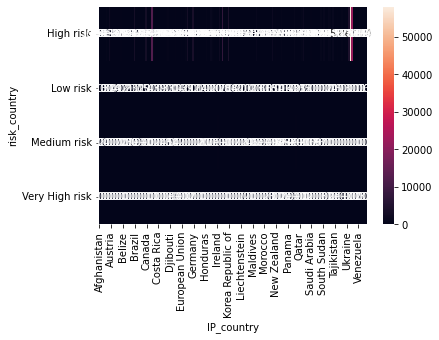

In [ ]:
sns.heatmap(datasetCR, annot=True)

In [ ]:
dataset.risk_country.unique()

array(['High risk', 'Very High risk', 'Medium risk', 'Low risk'],
      dtype=object)

In [ ]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(datasetCR) 
# Print the p-value
print("p value\t\t\t", p)

print("Chi2 Contingency\t", c)

p value			 0.0
Chi2 Contingency	 453336.0


## Check for correlated variables with various numerical variables as dependent variable

In [ ]:
model = ols('purchase_value ~ age_category + ip_address + seconds_since_signup + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.860848e+03,465.211876,1.385889,0.235933
month_purchase,11.0,5.592780e+03,508.434589,1.514652,0.118319
weekday_purchase,6.0,3.353721e+03,558.953496,1.665150,0.125044
risk_country,3.0,7.147424e+02,238.247453,0.709751,0.546019
period_of_the_day,5.0,5.600741e+03,1120.148159,3.336977,0.005140
sex,1.0,1.926256e+02,192.625635,0.573841,0.448738
browser,4.0,2.007321e+03,501.830240,1.494977,0.200660
source,2.0,1.493458e+01,7.467290,0.022245,0.978000
ip_address,1.0,5.395685e+00,5.395685,0.016074,0.899112
seconds_since_signup,1.0,1.961199e+01,19.611988,0.058425,0.809003


In [ ]:
model = ols('seconds_since_signup ~ age_category + ip_address + purchase_value + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.612254e+13,4.030634e+12,0.636573,6.363668e-01
month_purchase,11.0,5.186753e+17,4.715230e+16,7446.938991,0.000000e+00
weekday_purchase,6.0,3.827906e+13,6.379844e+12,1.007593,4.181108e-01
risk_country,3.0,6.529903e+12,2.176634e+12,0.343764,7.936808e-01
period_of_the_day,5.0,3.235919e+13,6.471838e+12,1.022122,4.025354e-01
sex,1.0,1.023447e+13,1.023447e+13,1.616368,2.036009e-01
browser,4.0,6.512102e+13,1.628025e+13,2.571202,3.589816e-02
source,2.0,1.153030e+13,5.765149e+12,0.910512,4.023206e-01
ip_address,1.0,3.110536e+12,3.110536e+12,0.491259,4.833674e-01
purchase_value,1.0,3.704994e+11,3.704994e+11,0.058514,8.088600e-01


## XGBoost


In [9]:
cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex', 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'quick_purchase', 'age_category', 'period_of_the_day', 'freq_same_purchase']])
numerical = dataset[['purchase_value', 'seconds_since_signup', 'age']]

data = pd.concat([cat_encoded, numerical], axis = 1)



In [10]:
X = data
y = dataset[['class']]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [22]:
from sklearn.utils import resample
train_df = pd.concat([X_train, y_train], axis=1)
not_fraud = train_df[train_df['class']==0]
fraud = train_df[train_df['class']==1]
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['class'].value_counts()

0    91777
1    91777
Name: class, dtype: int64

In [23]:
upsampled.to_csv("final_train.csv")

# Concat test dataframe and output this to csv as well
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv("final_test.csv")

In [24]:
pd.read_csv("final_train.csv", index_col=0)

,countries_from_device,quick_purchase,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,...,freq_same_purchase_2,freq_same_purchase_3,freq_same_purchase_4,freq_same_purchase_11-15,freq_same_purchase_5-10,freq_same_purchase_>15,purchase_value,seconds_since_signup,age,class
148220,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,35,3016960.0,25,0
117694,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,54,3940947.0,36,0
45471,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,74,858710.0,28,0
31507,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,25,1786460.0,19,0
61437,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,15,3642140.0,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96602,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,69,7252255.0,28,1
10672,1,1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,18,1.0,40,1
24239,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,29,1.0,36,1
16619,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,11,1.0,33,1


In [25]:
pd.read_csv("final_test.csv", index_col=0)

,countries_from_device,quick_purchase,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,...,freq_same_purchase_2,freq_same_purchase_3,freq_same_purchase_4,freq_same_purchase_11-15,freq_same_purchase_5-10,freq_same_purchase_>15,purchase_value,seconds_since_signup,age,class
33156,2,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,50,2747102.0,23,0
112858,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,36,9012968.0,47,0
94058,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,26,6959051.0,36,0
2610,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,18,6677138.0,28,0
96619,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,58,4340858.0,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144001,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,52,3239995.0,25,0
28204,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,44,1722791.0,30,0
57529,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,28,6136581.0,44,0
33174,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,18,4192255.0,33,0


In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


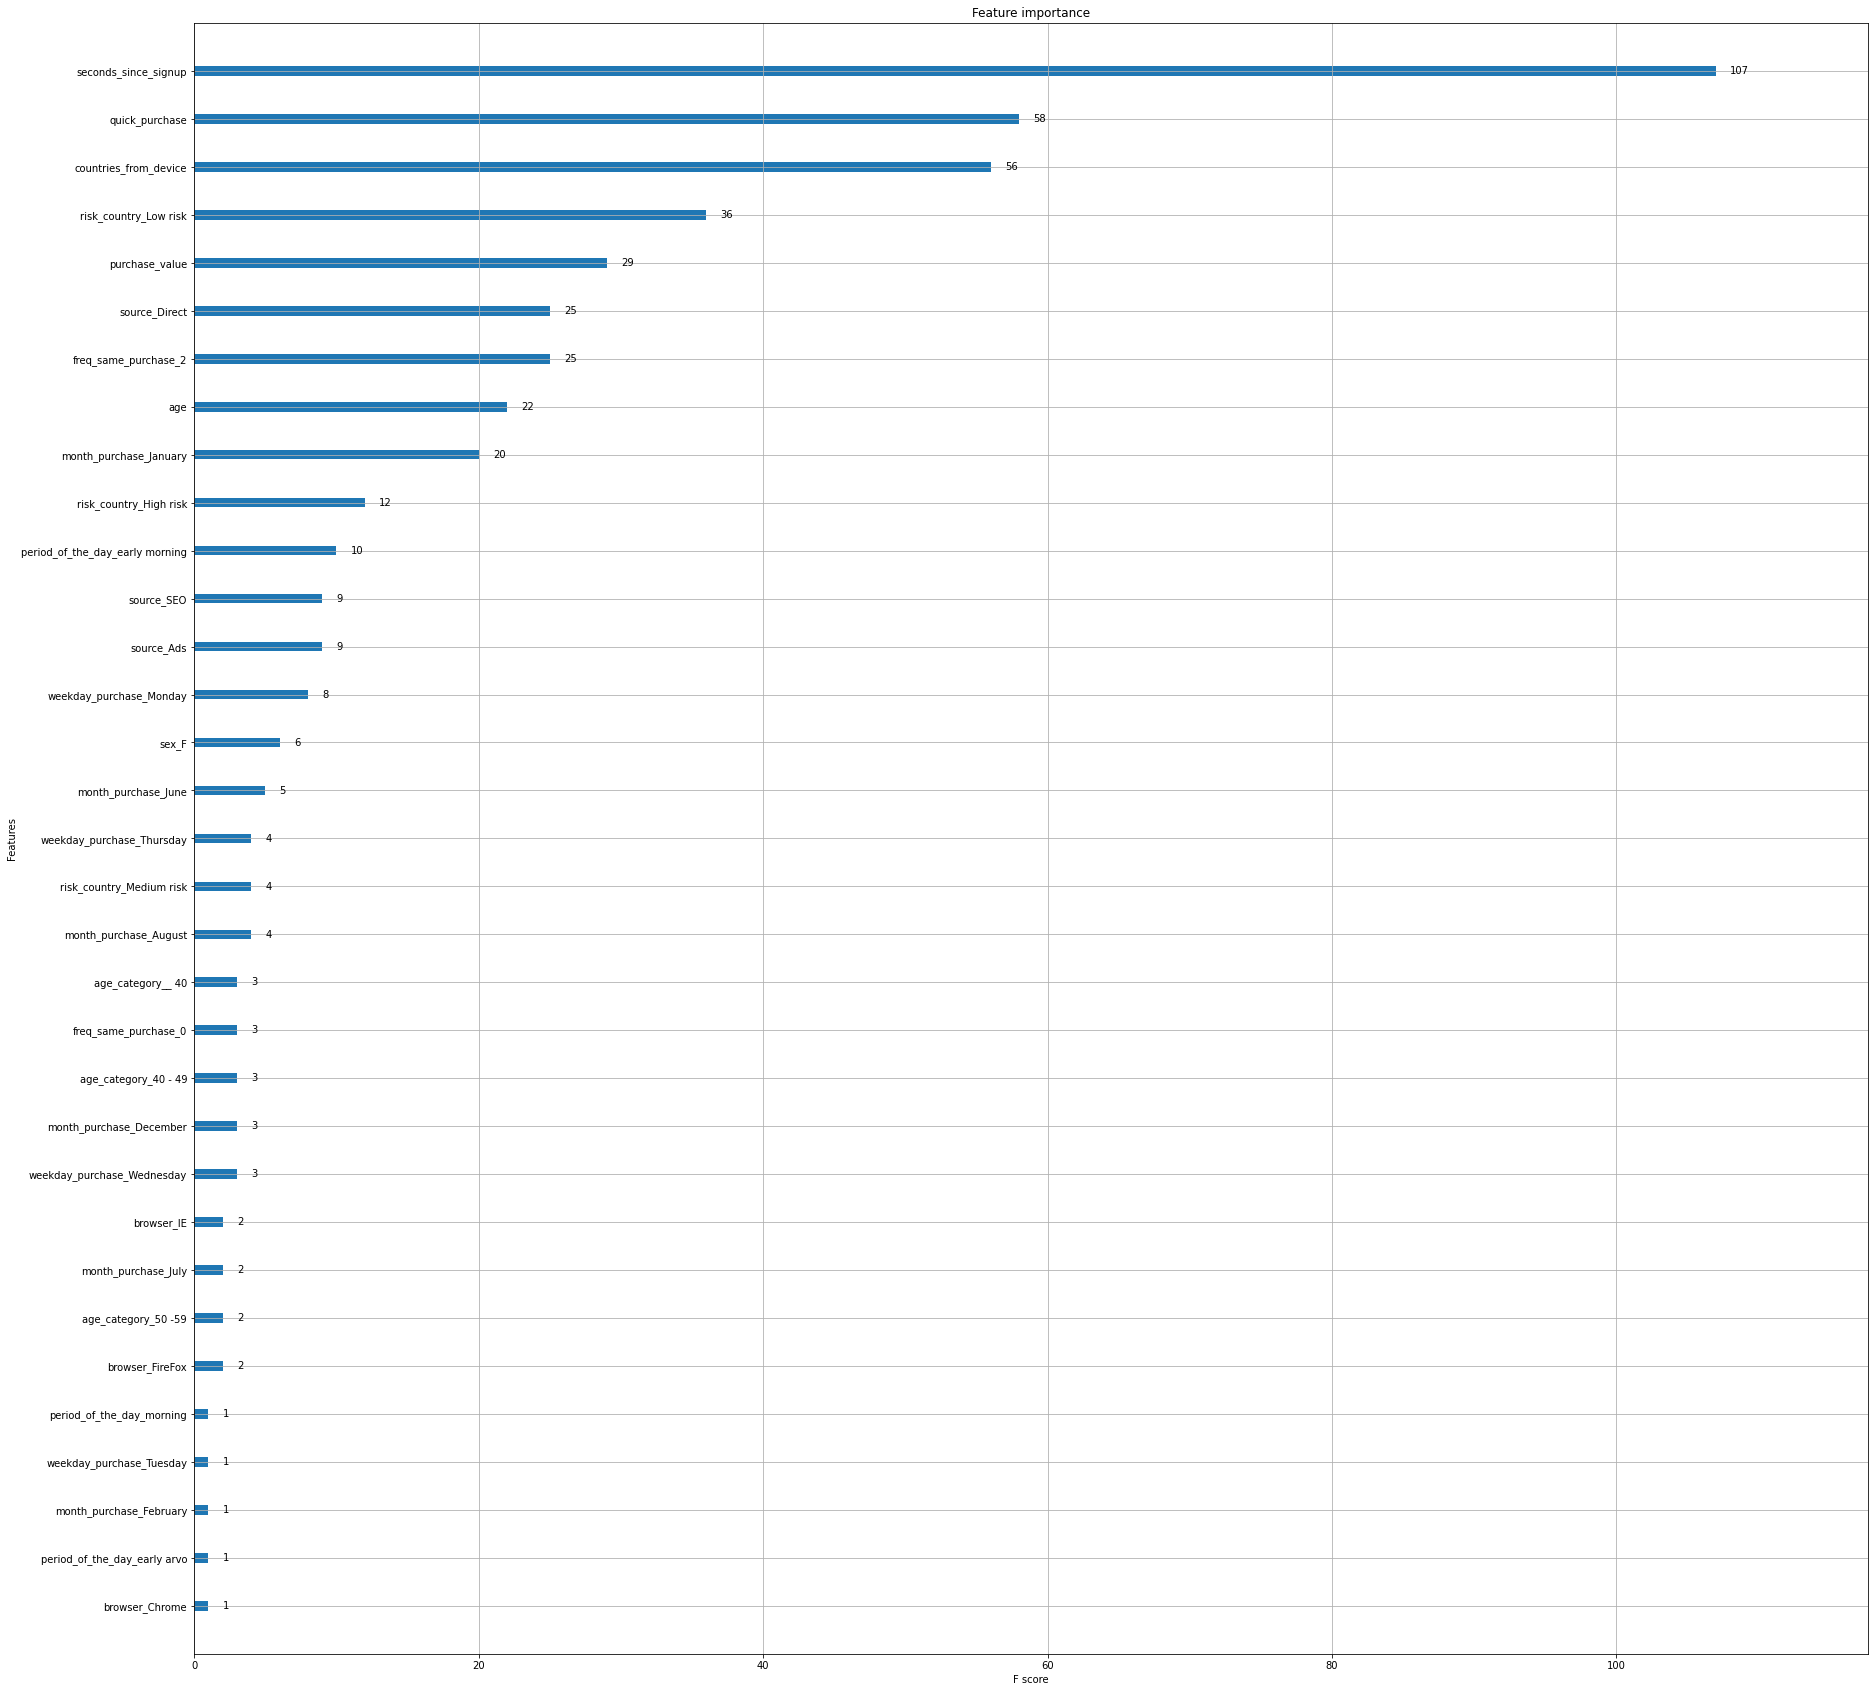

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.rcParams['figure.figsize'] = [30, 30]
display(plot_importance(model))

## RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=13, step=1)
selector = selector.fit(X_train, y_train)

selector.ranking_

array([ 1, 43, 18, 20, 23,  1,  2,  1, 25,  4,  1, 13,  5, 24, 36, 22, 31,
       12, 10, 17, 14, 27, 16,  7,  1, 19,  1,  9, 15,  3,  1, 32, 39, 37,
       35, 44, 21, 28, 40, 26,  1,  8, 11,  6,  1,  1, 29, 30, 42, 41, 33,
       34, 38,  1,  1,  1])

In [ ]:
ranking = pd.DataFrame([1, 43, 18, 20, 23,  1,  2,  1, 25,  4,  1, 13,  5, 24, 36, 22, 31,
       12, 10, 17, 14, 27, 16,  7,  1, 19,  1,  9, 15,  3,  1, 32, 39, 37,
       35, 44, 21, 28, 40, 26,  1,  8, 11,  6,  1,  1, 29, 30, 42, 41, 33,
       34, 38,  1,  1,  1], columns=["ranking"])
features = pd.DataFrame(['countries_from_device', 'quick_purchase', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'month_purchase_April', 'month_purchase_August',
       'month_purchase_December', 'month_purchase_February',
       'month_purchase_January', 'month_purchase_July', 'month_purchase_June',
       'month_purchase_March', 'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High risk',
       'risk_country_Low risk', 'risk_country_Medium risk',
       'risk_country_Very High risk', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category__ 40', 'period_of_the_day_arvo',
       'period_of_the_day_early arvo', 'period_of_the_day_early morning',
       'period_of_the_day_evening', 'period_of_the_day_late night',
       'period_of_the_day_morning', 'freq_same_purchase_0.0',
       'freq_same_purchase_2.0', 'freq_same_purchase_3.0',
       'freq_same_purchase_4.0', 'freq_same_purchase_11-15',
       'freq_same_purchase_5-10', 'freq_same_purchase_>15', 'purchase_value',
       'seconds_since_signup', 'age'], columns = ['features'])
feat_df = pd.concat([ranking, features], axis = 1)

In [ ]:
rslt_df = feat_df.loc[feat_df['ranking'] == 1]

In [ ]:
rslt_df

,ranking,features
0,1,countries_from_device
5,1,browser_Chrome
7,1,browser_IE
10,1,sex_F
24,1,weekday_purchase_Friday
26,1,weekday_purchase_Saturday
30,1,weekday_purchase_Wednesday
40,1,period_of_the_day_arvo
44,1,period_of_the_day_late night
45,1,period_of_the_day_morning


## Select the relevant columns for building the model

-- Upsampling not done yet

In [ ]:
final_df_X = data[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']]

In [ ]:
final_df_y = dataset[['class']]

In [ ]:
data.columns

Index(['countries_from_device', 'quick_purchase', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'month_purchase_April', 'month_purchase_August',
       'month_purchase_December', 'month_purchase_February',
       'month_purchase_January', 'month_purchase_July', 'month_purchase_June',
       'month_purchase_March', 'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High risk',
       'risk_country_Low risk', 'risk_country_Medium risk',
       'risk_country_Very High risk', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df_X, final_df_y, test_size=0.30, random_state=42)

In [ ]:
X_train

,countries_from_device,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_Safari,sex_F,weekday_purchase_Thursday,age_category_ > 70,age_category_40 - 49,age_category_50 -59,age_category_60 - 69,age_category_< 40,period_of_the_day_arvo,purchase_value,seconds_since_signup
84579,1,0,0,1,0,0,0,0,0,0,0,0,1,0,44,2993371.0
107117,1,0,0,1,1,0,1,0,0,1,0,0,0,0,28,9026734.0
35677,2,1,0,0,1,0,0,0,0,0,0,0,1,0,67,7268453.0
118485,1,0,0,1,1,0,0,0,0,0,0,0,1,0,24,10226468.0
20376,1,1,0,0,1,0,0,0,0,1,0,0,0,0,12,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50683,2,0,0,1,0,1,0,1,0,0,0,0,1,0,40,8657445.0
67590,1,0,1,0,0,1,0,0,0,0,0,0,1,0,40,3396055.0
122955,1,0,1,0,0,0,0,0,0,1,0,0,0,0,50,9152217.0
137829,1,0,0,1,0,0,0,0,0,0,0,0,1,0,76,1911779.0


In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rfc.fit(X_train, y_train)

rfc.decision_path(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


(<105778x1421352 sparse matrix of type '<class 'numpy.int64'>'
 	with 212199054 stored elements in Compressed Sparse Row format>,
 array([      0,   14005,   27952,   42331,   56964,   71519,   84946,
          98773,  113700,  128035,  141832,  155817,  169736,  184027,
         198088,  212183,  226348,  240567,  255316,  269099,  283162,
         297041,  310610,  324923,  338934,  352975,  367220,  381767,
         395936,  409959,  424090,  438251,  452916,  466911,  482504,
         496531,  511202,  524909,  539212,  552915,  567290,  581673,
         596142,  610645,  624482,  638391,  652564,  666317,  680898,
         695829,  710034,  724237,  738170,  752399,  766704,  781057,
         795068,  809661,  824944,  839593,  854176,  868699,  882546,
         896513,  910380,  924897,  938788,  952991,  967254,  981513,
         995878, 1009799, 1023618, 1037457, 1051548, 1065659, 1079966,
        1094351, 1109372, 1123493, 1137484, 1152123, 1166050, 1180135,
        1193944, 1

In [ ]:
y_pred = rfc.predict(X_test)

from sklearn import metrics 

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9497507389597212


In [ ]:
## Other metrics

print("precision score OF THE MODEL: ", metrics.precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", metrics.recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", metrics.f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", metrics.roc_auc_score(y_test, y_pred))

precision score OF THE MODEL:  0.8708473310936917
recall score OF THE MODEL:  0.547010550996483
f1 score OF THE MODEL:  0.6719470046082948
ROC AUC score OF THE MODEL:  0.7692928525027949
